# Simple model of the Nordic energy market

This model does not include the interaction and thus possible congestion between markets into account. 

#### Imports 

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers 
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp 
from jax import random, vmap
from jax.scipy.special import logsumexp 
from jax import lax 

# matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

Load the data

In [3]:
df = pd.read_csv("data/2023/day_ahead_prices.csv")
df = df[df['country_code'] == "DK_1"]
df.rename(columns={'Unnamed: 0': 'Time', '0': 'Price'}, inplace=True)
df.head

<bound method NDFrame.head of                            Time  Price country_code
0     2023-01-01 00:00:00+01:00   2.01         DK_1
1     2023-01-01 01:00:00+01:00   1.38         DK_1
2     2023-01-01 02:00:00+01:00   0.09         DK_1
3     2023-01-01 03:00:00+01:00   0.08         DK_1
4     2023-01-01 04:00:00+01:00   0.05         DK_1
...                         ...    ...          ...
8755  2023-12-31 19:00:00+01:00  39.64         DK_1
8756  2023-12-31 20:00:00+01:00  34.89         DK_1
8757  2023-12-31 21:00:00+01:00  29.60         DK_1
8758  2023-12-31 22:00:00+01:00  28.67         DK_1
8759  2023-12-31 23:00:00+01:00  26.87         DK_1

[8760 rows x 3 columns]>

In [4]:
print("Dataset size:", len(df))
print("General statistics:")
df.describe()

Dataset size: 8760
General statistics:


,Price
count,8760.000000
mean,86.826501
std,48.823730
min,-440.100000
25%,60.000000
50%,92.040000
75%,114.707500
max,524.270000


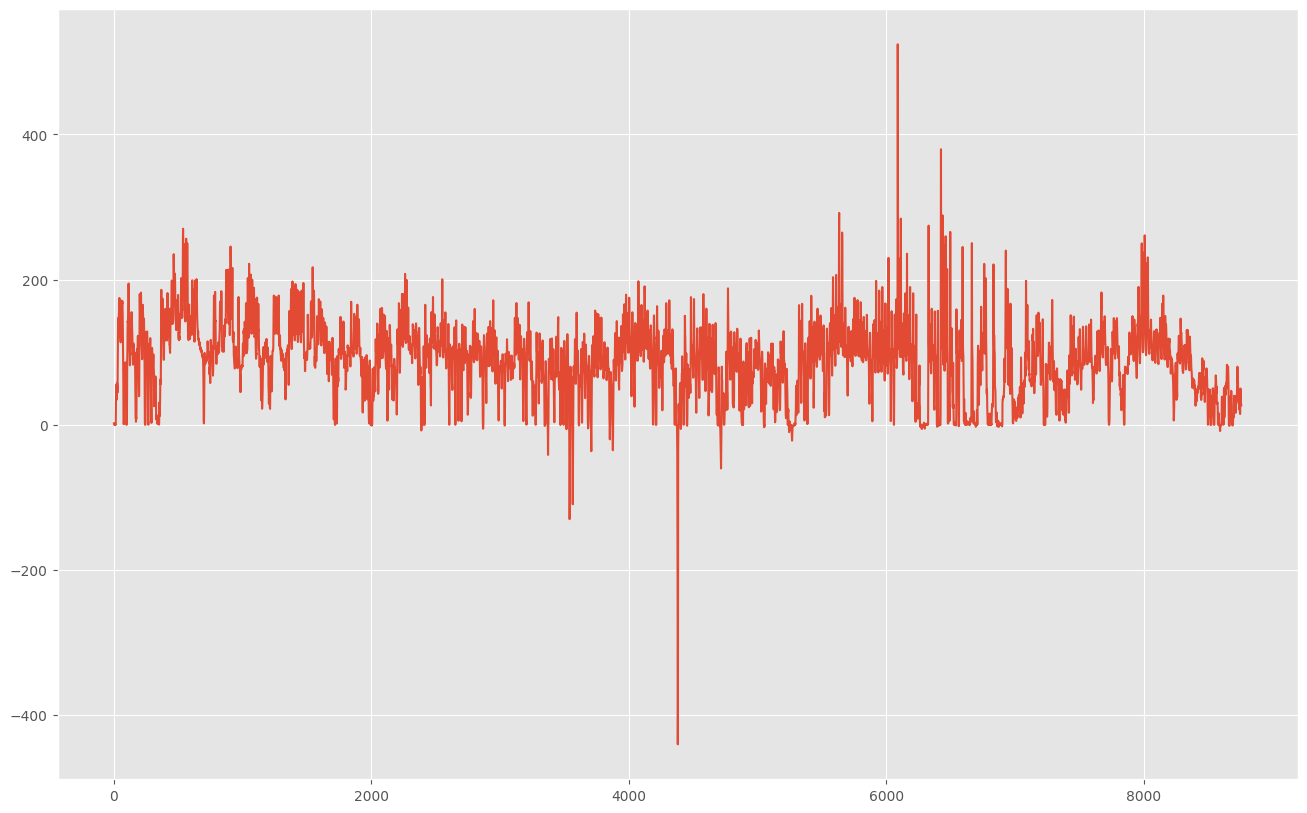

In [5]:
# Visualization
plt.plot(df['Price'])


In [6]:
# convert data to a matrix
y = df['Price'].values
N = len(y)
print("N=%d" % (N))

N=8760


In [6]:
# Remove missing data
missing_perc = 0

perm1 = np.random.permutation(N)
ix_mis1 = perm1[:int(missing_perc * N)]
ix_obs1 = perm1[int(missing_perc * N):]
y_mis1 = y[ix_mis1]
y_obs1 = y[ix_obs1]

N_obs = len(ix_obs1)
N_mis = len(ix_mis1)
N = N_obs + N_mis
print("N_obs:", N_obs)
print("N_mis:", N_mis)

N_obs: 8760
N_mis: 0


Define carry function for `jax.lax.scan`

In [7]:
def f(carry, noise_t):
    beta, z_prev, tau = carry
    z_t = beta*z_prev + tau*noise_t 
    z_prev = z_t
    return (beta, z_prev, tau), z_t

Define the NumPyro model

In [8]:
def model(T, T_forecast, obs=None, ix_mis=None, ix_obs=None):
    # Define priors over B, R, W, c
    beta = numpyro.sample(name="beta", fn=dist.Normal(loc=0., scale=1))
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=.1))
    noises = numpyro.sample("noises", fn=dist.Normal(0, 1.), sample_shape=(T+T_forecast-1,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=.1))
    z_prev = numpyro.sample(name="z_1", fn=dist.Normal(loc=0, scale=.1))

    # Propagate the dynamics using jax.lax.scan
    carry = (beta, z_prev, tau)
    z_collection = [z_prev]
    carry, zs_exp = lax.scan(f, carry, noises, T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)

    # Sample observed and missing values
    numpyro.sample(name="y_mis", fn=dist.Normal(loc=z_collection[ix_mis], scale=sigma), obs=None)
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[ix_obs], scale=sigma), obs=obs[ix_obs])
    return z_collection

In [9]:
# Inference

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
nuts_kernel = NUTS(model=model)
mcmc = MCMC(nuts_kernel, num_samples=1000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=N, T_forecast=0, obs=y, ix_mis=ix_mis1, ix_obs=ix_obs1)


sample: 100%|██████████| 2000/2000 [03:46<00:00,  8.83it/s, 76 steps of size 1.07e-03. acc. prob=0.19]  


In [7]:
mcmc.print_summary()

NameError: name 'mcmc' is not defined

In [ ]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

In [11]:
nodes = ["beta", "tau", "sigma"]
for node in nodes:
    plt.figure(figsize=(4,3))
    sns.histplot(hmc_samples[node], label=node, kde=True, stat="density")
    plt.legend()
    plt.show()

NameError: name 'hmc_samples' is not defined

<Figure size 400x300 with 0 Axes>

In [ ]:
y_hat = hmc_samples["y_mis"].mean(axis=0)
y_std = hmc_samples["y_mis"].std(axis=0)

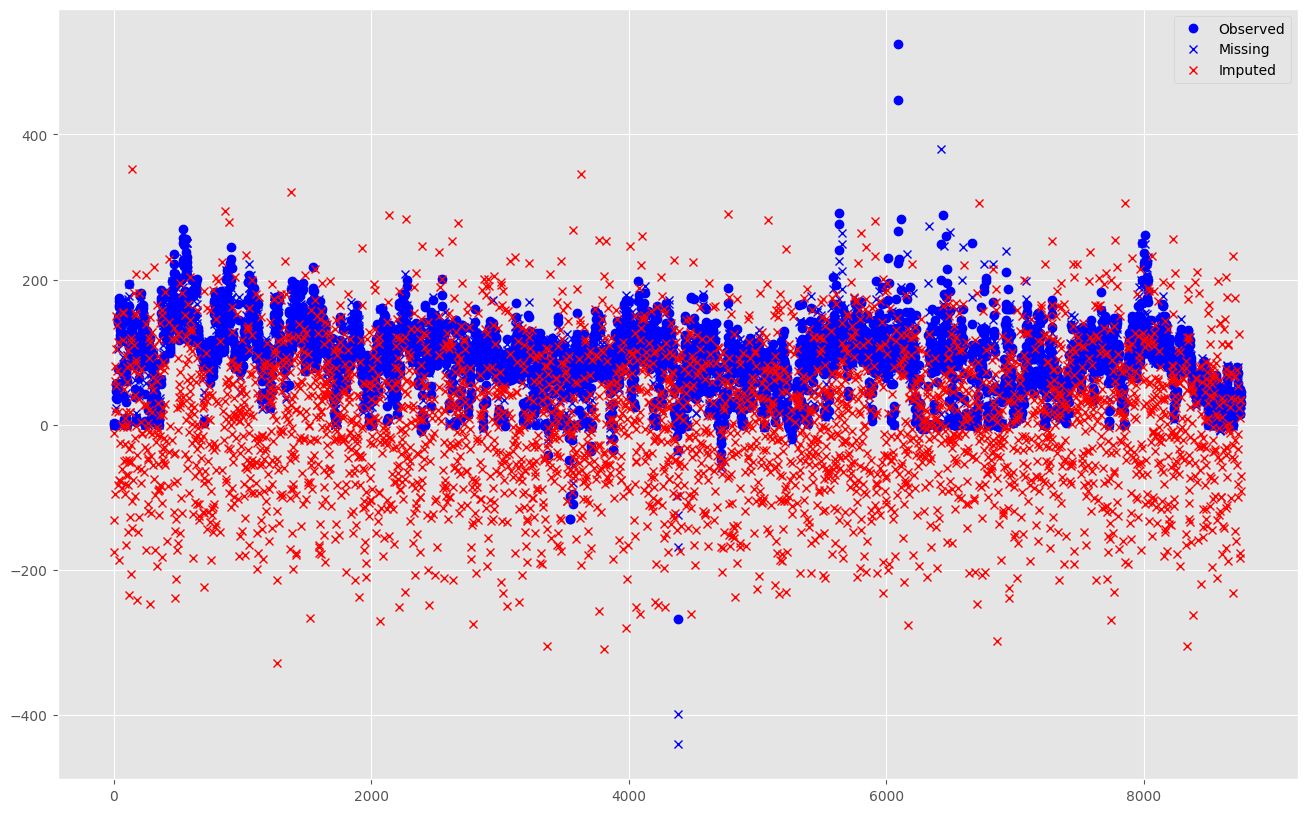

In [ ]:
plt.plot(ix_obs1, y_obs1, "bo")
plt.plot(ix_mis1, y_mis1, "bx")
plt.plot(ix_mis1, y_hat, "rx")
plt.legend(["Observed", "Missing", "Imputed"]);

In [ ]:
def compute_error(trues, predicted):
    import numpy
    corr = numpy.corrcoef(predicted, trues)[0,1]
    mae = numpy.mean(np.abs(predicted - trues))
    rae = numpy.sum(numpy.abs(predicted - trues)) / numpy.sum(numpy.abs(trues - numpy.mean(trues)))
    rmse = numpy.sqrt(numpy.mean((predicted - trues)**2))
    r2 = max(0, 1 - numpy.sum((trues-predicted)**2) / numpy.sum((trues - numpy.mean(trues))**2))
    return corr, mae, rae, rmse, r2

In [ ]:
corr, mae, rae, rmse, r2 = compute_error(y_mis1, y_hat)
print("CorrCoef: %.3f\nMAE: %.5f\nRMSE: %.5f\nR2: %.3f" % (corr, mae, rmse, r2))

CorrCoef: 0.016
MAE: 110.53215
RMSE: 137.69586
R2: 0.000
